# Prediction of Diabetes based on given attribute using PIMA Diabetes dataset

In [1]:
import numpy as np   
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#models
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from keras.models import Sequential
from keras.layers import Dense
#Evaluation
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate,cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve,auc
#for warning 
from warnings import filterwarnings
filterwarnings("ignore")


## Function definations 

In [2]:
def violin_plot(nrow=4,ncol=2): 
    """
    funtion to plot violin plot for all attributes
    
    input : optional input for number of column and rows for subplot by default value are 2,4 respectively
    
    output : violin plot for all attribute of dataframe 
    
    return : none
    """
    fig = plt.figure(figsize=(14,25))
    fig.tight_layout(pad=3.0)
    nrow,ncol,index=4,2,1    
    for attribute in attributes:
        plt.subplot(nrow, ncol, index)
        plt.title(attribute)
        sns.violinplot(x="Outcome", y=attribute, data=data)
        index+=1
    plt.show()
    
##############################################################################################################
        
def plot_roc(fpr,tpr,auc_model,name_of_algo):
    """
    This function pots the ROC curve with help of False positive rate
    and True positive rate and auc object
    
    input : false positive rate, ture positive rate,auc of model,name_of_algo
    
    output : ROC plot 
    
    return : None
    """
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc_model))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve of '+name_of_algo)
    plt.legend(loc='best')
    plt.show()
 
#############################################################################################################

# calculation of median for each attribute for both possible outcome  
def median_target(attribute):
    """
    This function replaces the Nan of given attribute with 
    median when grouped by Outcome into the global variable 
    data("dataframe")
    
    input : attribute 
    
    output : column of that attibute is modified 
    
    return : none
    """
    temp = data[data[attribute].notnull()]# assigning non null value to temp 
    temp = temp[[attribute, 'Outcome']].groupby(['Outcome'])[[attribute]].median().reset_index() #calculate mean for a attribute with either 0 or      1 outcome 
    mean_op_0=temp[attribute][0]
    mean_op_1=temp[attribute][1]
    data.loc[(data['Outcome'] == 0 ) & (data[attribute].isnull()), attribute] = mean_op_0 #assigning mean to null values 
    data.loc[(data['Outcome'] == 1 ) & (data[attribute].isnull()), attribute] = mean_op_1
    
##############################################################################################################

def median_target_all():
    # calling meadian_target for each attribute
    for attribute in attributes:
            median_target(attribute) 

##############################################################################################################
        
def outliers_removal():
    """
    This function removes outlier of the global variable data(dataframe)
    using IQR method 
    """
    #loop for replacing outlier of all attribute with Nan value 
    for attribute in attributes:
        q1 = data[attribute].quantile(0.25)
        q3 = data[attribute].quantile(0.75)
        iqr = q3 - q1
        fence_low = q1 - 1.5 * iqr 
        fence_high = q3 + 1.5 * iqr
        data.loc[(data[attribute] < fence_low) | (data[attribute] > fence_high),attribute]=np.nan

##############################################################################################################
        
def z_score(df):
    """Function for apply z score standardization
    
       Input: dataframe to be standardized
       
       output :standardized dataframe 
    """
    df_std = df.copy()
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()     
    return df_std

##############################################################################################################

def plot_confusion_matrix(df_cm,name_of_algo):
    sns.heatmap(df_cm, annot=True,fmt="d")
    plt.title(name_of_algo)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()  

##############################################################################################################

def model_evalution(model,name_of_algo,X,y,score,final_Result):
    model_score=cross_validate(model,X,y,cv=10,scoring=score)
    y_pred_cross = cross_val_predict(model,X,y,cv=10)
    conf_mat = confusion_matrix(y, y_pred_cross)
    df_cm = pd.DataFrame(conf_mat)
    sensitivity = conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1]) # TPR, REC,sensitivity = TP / (TP + FN)
    specificity = conf_mat[1,1]/(conf_mat[1,0]+conf_mat[1,1])# specificity = TN / (TN + FP)
    precision =conf_mat[0,0]/(conf_mat[0,0]+conf_mat[1,1])# PREC, PPV =TP / (TP + FP)
    f1_score= 2*sensitivity*precision/(precision+sensitivity) # 2 * PREC * REC / (PREC + REC)
    avg_auc="{:.3f} +- {:.3f}".format((model_score["test_roc_auc"].mean()*100),(model_score["test_roc_auc"].std()))
    avg_auc="{:.3f} +- {:.3f}".format((model_score["test_roc_auc"].mean()*100),(model_score["test_roc_auc"].std()))
    avg_accuracy="{:.3f} +- {:.3f}".format((model_score["test_accuracy"].mean()*100),(model_score["test_accuracy"].std()))
    final_Result["Specificity"].append(specificity)
    final_Result["Sensitivity/Recall"].append(sensitivity)
    final_Result["Precision"].append(precision)
    final_Result["F1 Score"].append(f1_score)
    final_Result["Accuracy"].append(avg_accuracy)
    final_Result["AUC(ROC)"].append(avg_auc)
    final_Result["Model"].append(name_of_algo)
    return final_Result,df_cm

    

In [3]:
# loading of PIMA dataset 
data = pd.read_csv("diabetes.csv")
# assigning independent variable to attributes 
attributes = data.drop("Outcome",axis=1).columns

### Attributes
    1. Pregnancies: Number of times pregnant
    2. Glucose : Plasma glucose concentration a 2 hours in an oral glucose tolerance test
    3. BloodPressure : Diastolic blood pressure (mm Hg)
    4. SkinThickness : Triceps skin fold thickness (mm)
    5. Insulin : 2-Hour serum insulin (mu U/ml)
    6. BMI : Body mass index (weight in kg/(height in m)^2)
    7. DiabetesPedigreeFunction : It provided some data on diabetes mellitus history in relatives and the genetic           relationship of those relatives to the patient.
    8. Age : Age (years)
    9. Outcome : Class variable (0 or 1) 268 of 768 are 1, the others are 0

## EDA

In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:

data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


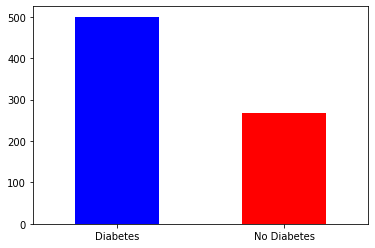

In [7]:
ax=data["Outcome"].value_counts().plot(kind="bar",color=["blue","red"])
ax.set_xticklabels(['Diabetes','No Diabetes'],rotation=0);

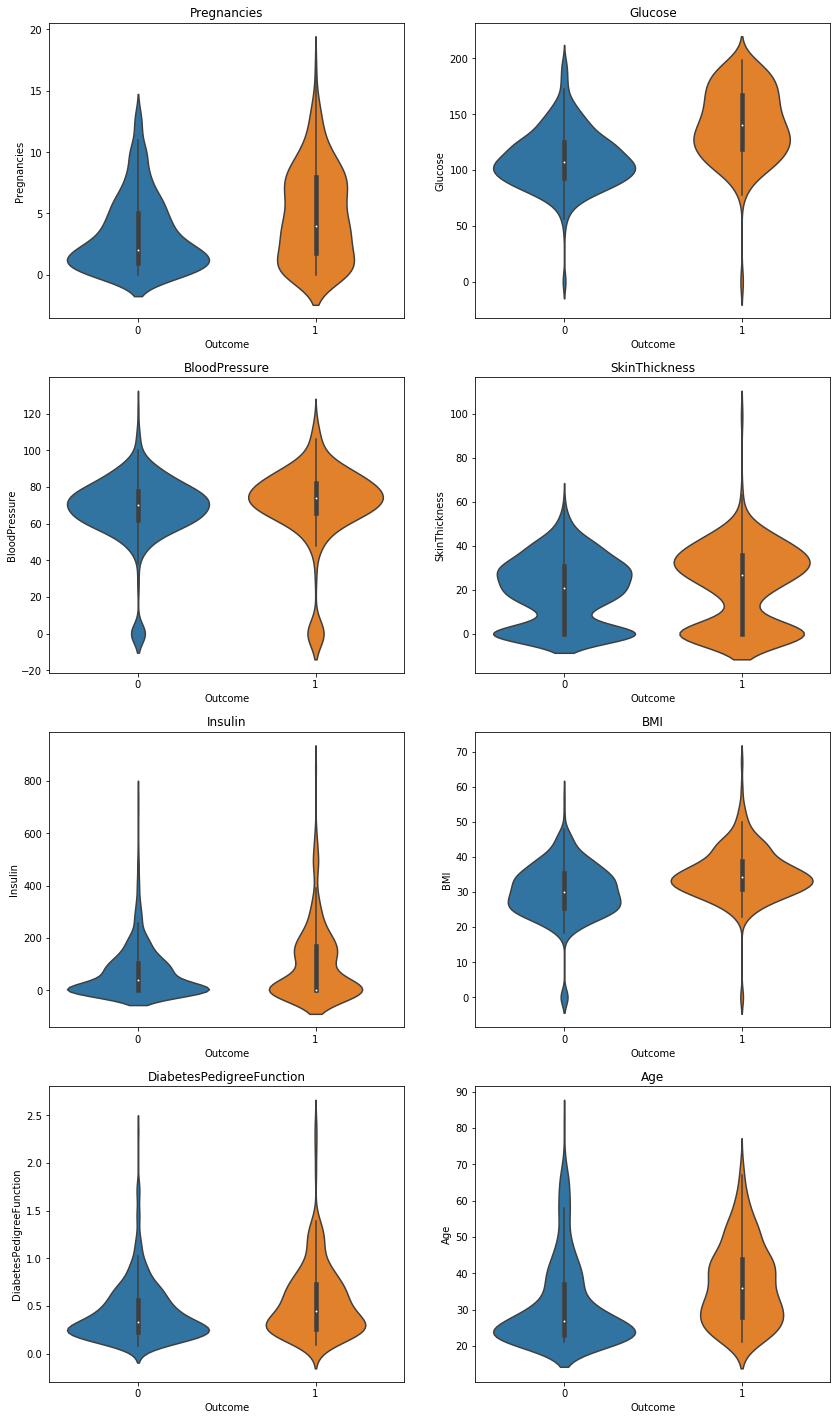

In [8]:
violin_plot()

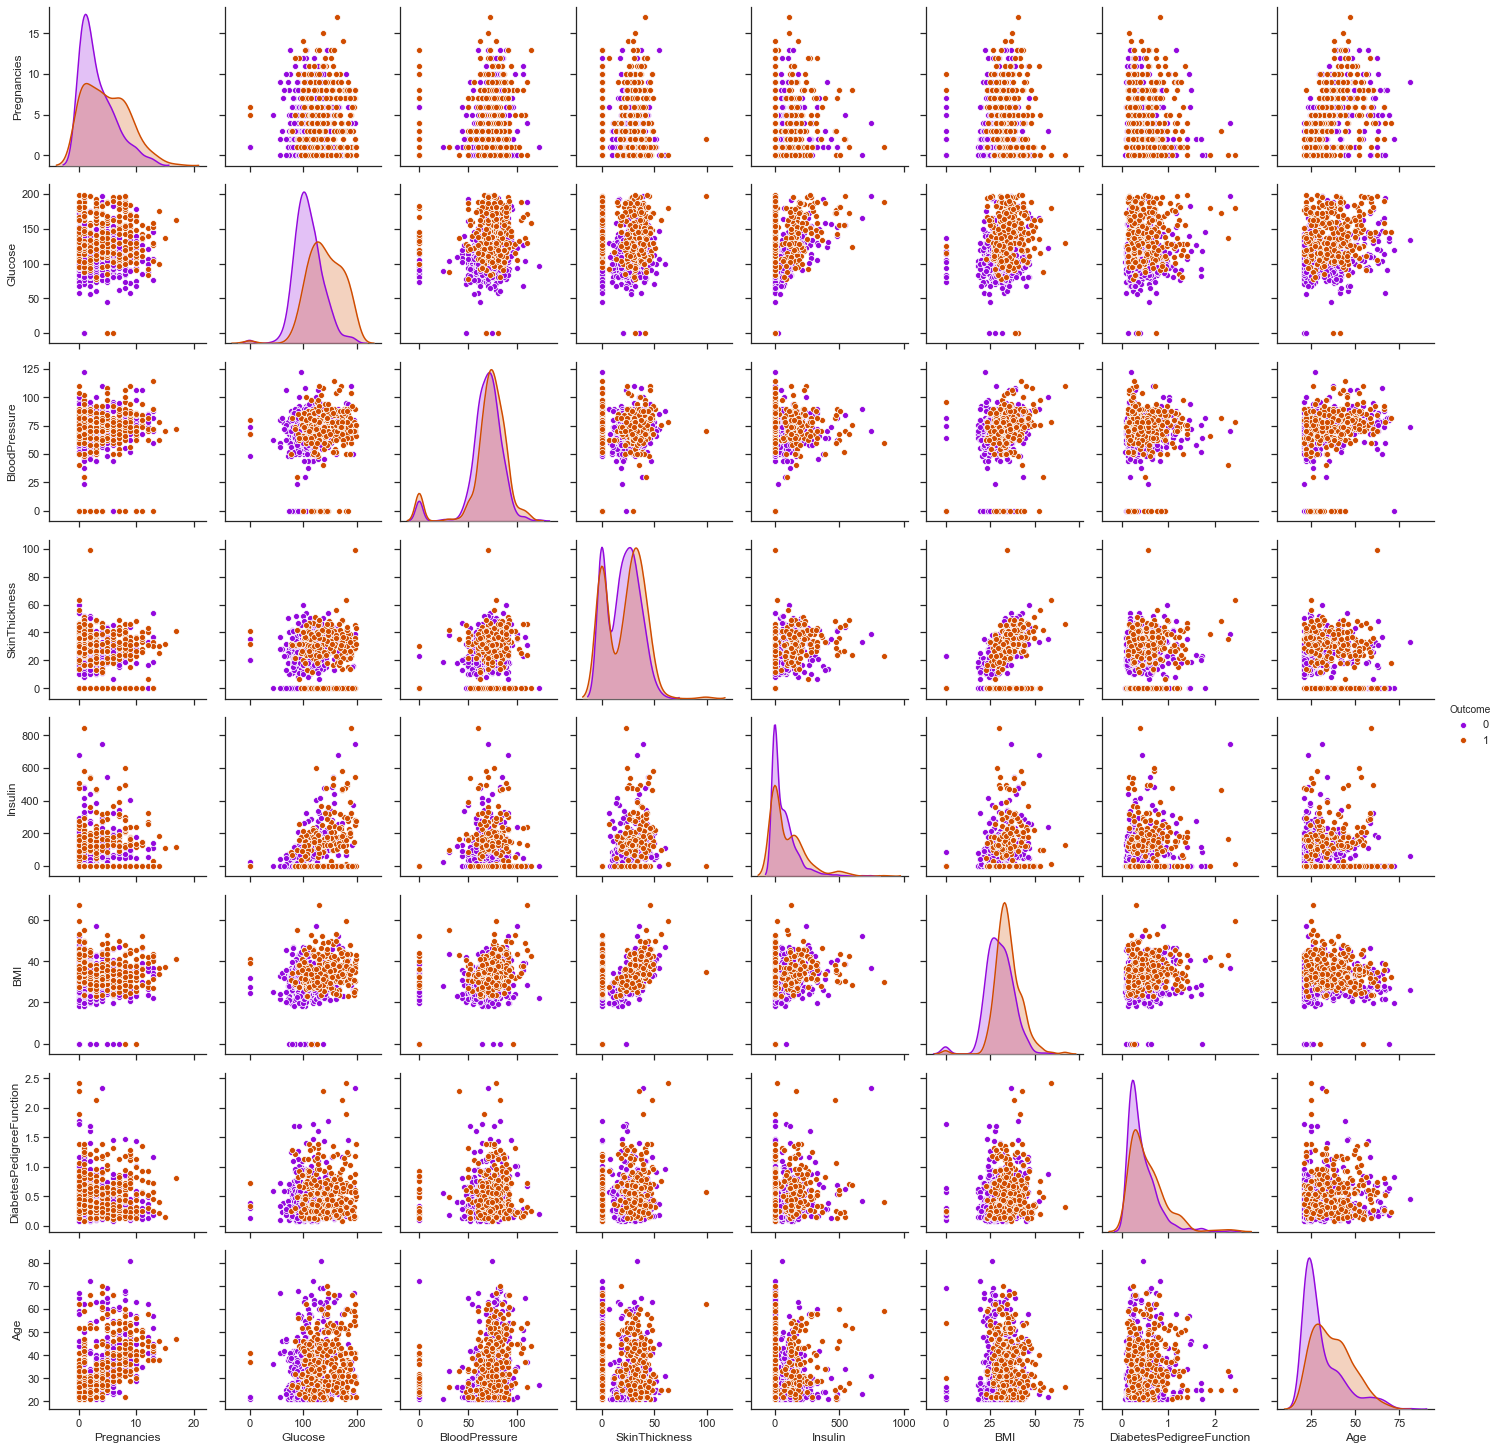

In [9]:
# Pairwise plot of all attributes 
sns.set(style="ticks", color_codes=True)
sns.pairplot(data,hue='Outcome',palette='gnuplot');

## Data processing 

In [10]:
# replacing missing value with nan value
nan_replacement_att=["Glucose",  "BloodPressure","SkinThickness","Insulin","BMI"]
data[nan_replacement_att]=data[nan_replacement_att].replace(0,np.nan)

median_target_all()  # median_target_all replaces nan value with median of that attribute grouped by outcome 

In [11]:
outliers_removal() # replacing outliers with Nan 

median_target_all()

In [12]:
print(data.isna().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


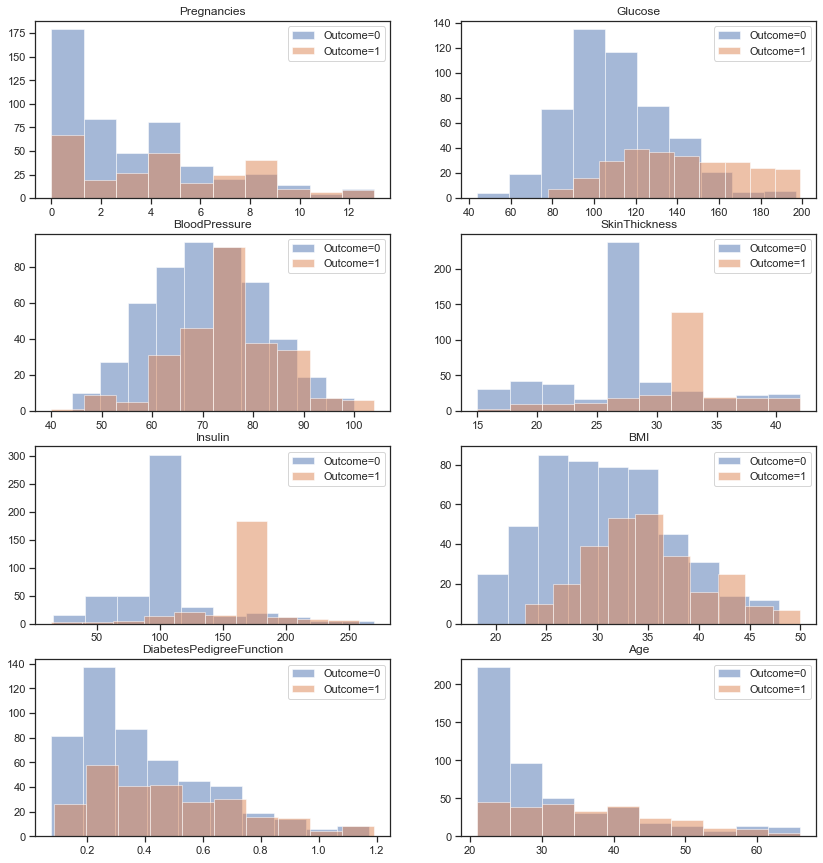

In [13]:
fig = plt.figure(figsize=(14,15))
fig.tight_layout(pad=3.0)
nrow,ncol,index=4,2,1    
for attribute in attributes:
    plt.subplot(nrow, ncol, index)
    plt.title(attribute)
    plt.hist(data[attribute][data.Outcome==0],alpha=0.5,label="Outcome=0")
    plt.hist(data[attribute][data.Outcome==1],alpha=0.5,label="Outcome=1")
    plt.legend(loc="best")
    index+=1
plt.show()


In [14]:

#sns.set(style="ticks", color_codes=True)
#sns.pairplot(data,hue='Outcome',palette='gnuplot');


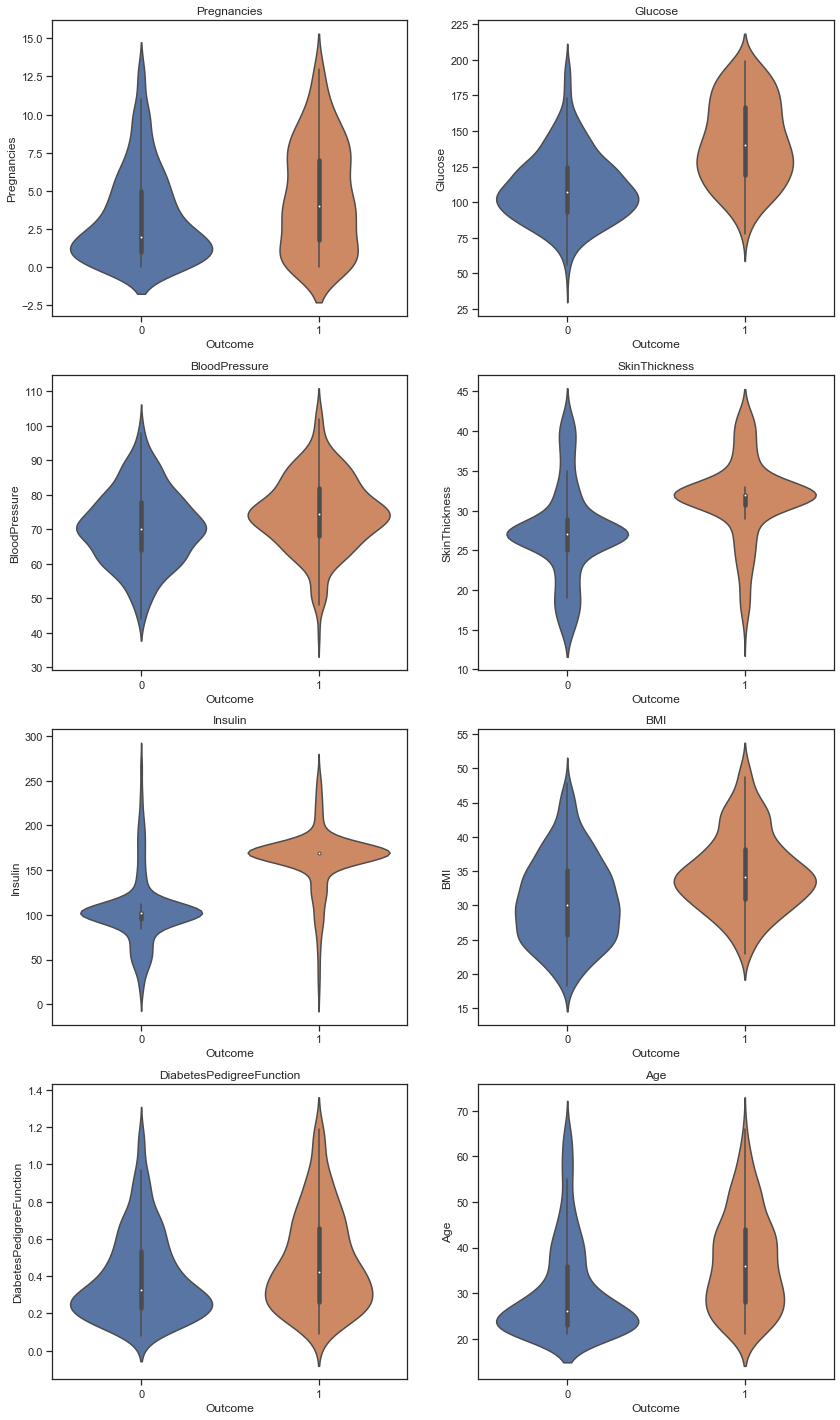

In [15]:
violin_plot()

In [16]:
# standardization of dataset
data_std=z_score(data)
data_std.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02
mean,-3.151414e-17,1.470178e-16,-1.673285e-17,9.540979e-18,9.504839e-17,4.681224e-15,8.683737e-16,-2.515349e-16,3.189000e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.158269e+00,-2.549786e+00,-2.948824e+00,-2.295930e+00,-2.390541e+00,-2.180321e+00,-1.427112e+00,-1.061739e+00,-7.316434e-01
25%,-8.524767e-01,-7.197665e-01,-7.447396e-01,-2.853550e-01,-4.743078e-01,-7.314393e-01,-7.513126e-01,-7.906871e-01,-7.316434e-01
50%,-2.408914e-01,-1.535274e-01,-1.004466e-02,-2.853550e-01,-4.743078e-01,-3.036760e-02,-2.732586e-01,-3.389331e-01,-7.316434e-01
75%,6.764867e-01,6.096645e-01,7.246503e-01,5.523844e-01,9.763999e-01,6.395454e-01,6.288261e-01,6.549256e-01,1.365006e+00
max,2.817035e+00,2.538160e+00,2.928735e+00,2.227863e+00,3.152461e+00,2.773919e+00,3.110833e+00,3.004046e+00,1.365006e+00


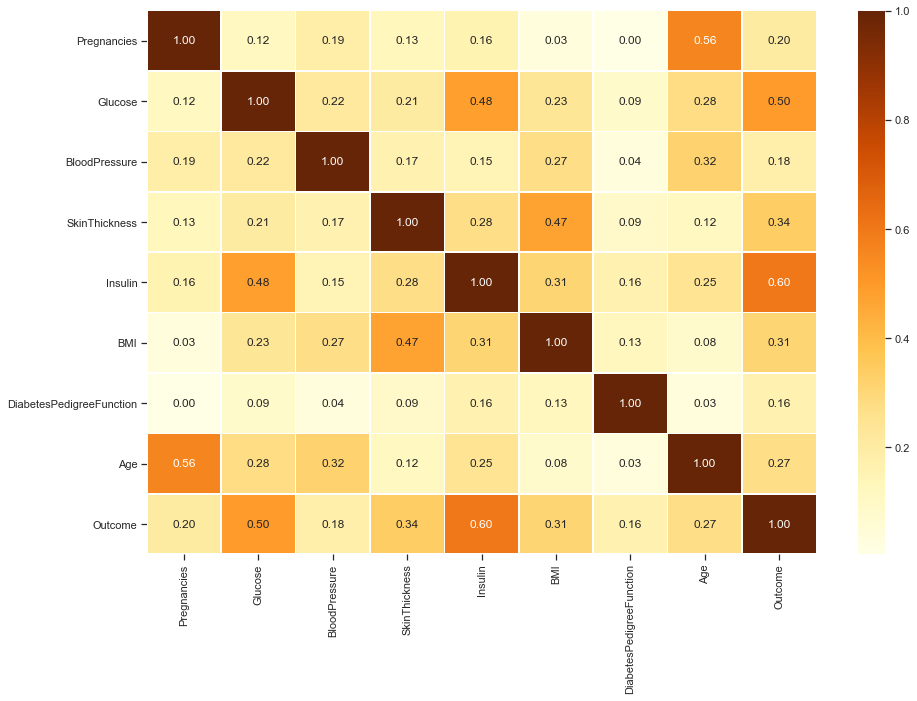

In [17]:
# It shows the correlation(positive,neagative) between different columns(only integer value columns) 
corr_matrix = data_std.corr()
fig,ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,annot=True,linewidth=0.5,fmt=".2f",cmap="YlOrBr")

###### Distribution of data set 

In [18]:
y = data["Outcome"]
X=data_std.drop("Outcome",axis=1)
X_train,X_test,y_train,y_test =  train_test_split(X,y,test_size=0.2)

## Models 

### Code using PCA for reducing dimensionality 
``` python 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
for i in range(1,9):

    list_of_algo=[LogisticRegression(),GaussianNB(),SVC(probability=True),KNeighborsClassifier(),
                  RandomForestClassifier(),AdaBoostClassifier(),XGBClassifier()]

    name_of_algo=["LogisticRegression","GaussianNB","SVM","KNeighborsClassifier",
                  "RandomForestClassifier","AdaBoostClassifier","XGBClassifier"]
    for i,algorithm in enumerate(list_of_algo):
        steps = [('pca', PCA(n_components=i)), ('m', algorithm)]
        model = Pipeline(steps=steps)

        #### Evaluate model
        model_score = cross_val_score(model, X, y, scoring='roc_auc',cv=10)
        print("*"*120)
        print('Accuracy of {} : {} '.format(name_of_algo[i],(model_score.mean()*100)))
    print(" ")
    print("#"*120)
    print("")
```


************************************************************************************************************************

[[0.28613409 0.83058792 0.02042889 0.53751528 1.29571254 0.22256421
  0.2426565  0.22144312]]



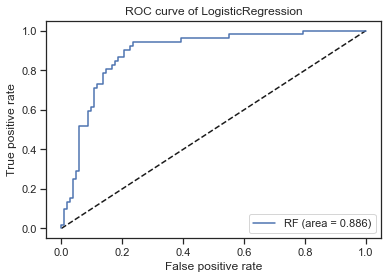

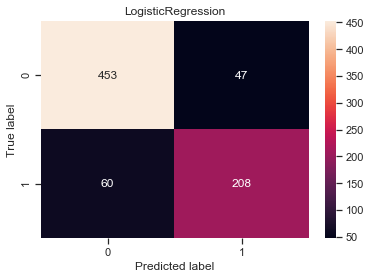

************************************************************************************************************************

null



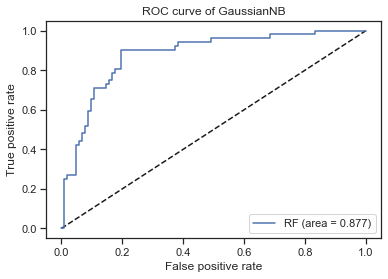

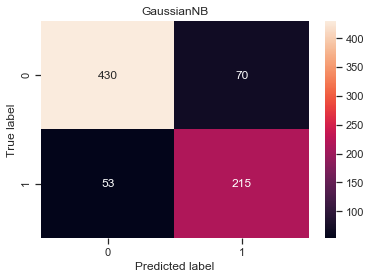

************************************************************************************************************************

null



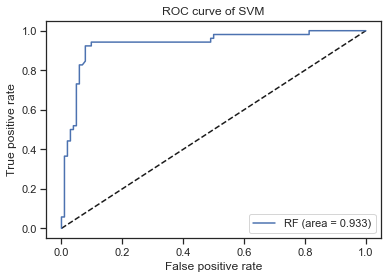

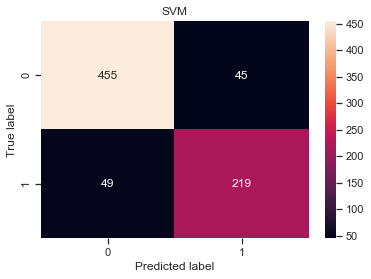

************************************************************************************************************************

null



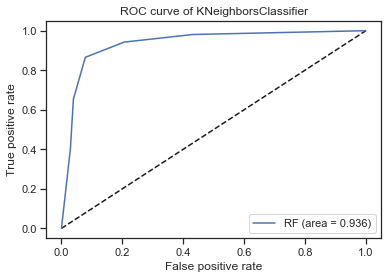

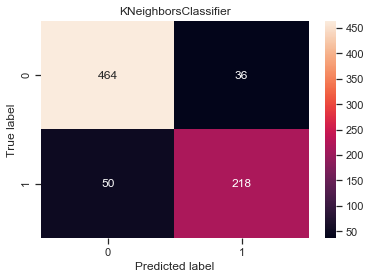

************************************************************************************************************************

[0.03884899 0.14452661 0.04269522 0.17922283 0.37367085 0.0802769
 0.05772584 0.08303276]



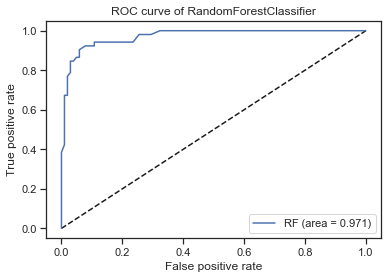

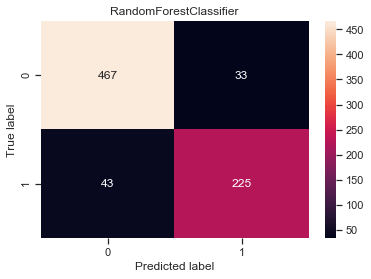

************************************************************************************************************************

[0.08 0.1  0.04 0.16 0.4  0.08 0.06 0.08]



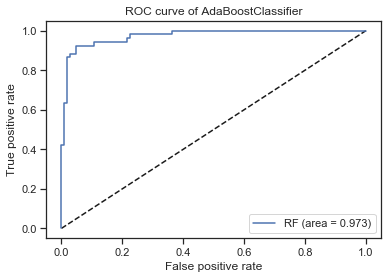

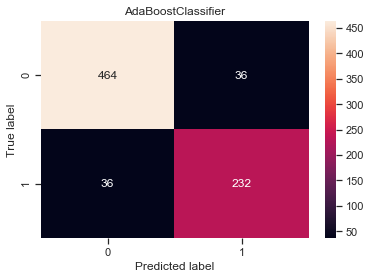

[14:49:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:49:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:49:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:49:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

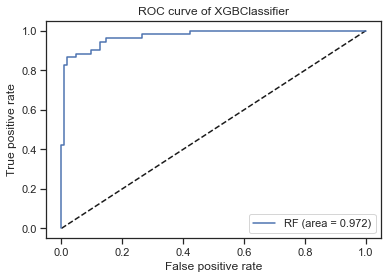

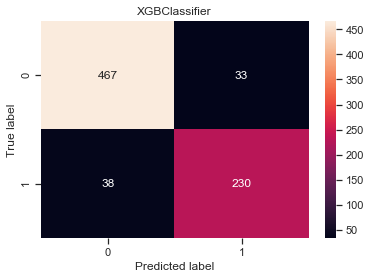

In [19]:
from collections import defaultdict
list_of_algo=[LogisticRegression(),GaussianNB(),SVC(probability=True),KNeighborsClassifier(),
              RandomForestClassifier(),AdaBoostClassifier(),XGBClassifier()]

name_of_algo=["LogisticRegression","GaussianNB","SVM","KNeighborsClassifier",
              "RandomForestClassifier","AdaBoostClassifier","XGBClassifier"]

score = {"accuracy": "accuracy",
         "prec": "precision","recall" : "recall",
         "f1" : "f1","roc_auc" : "roc_auc"}
final_Result= defaultdict(list)
for i,algorithm in enumerate(list_of_algo):
    model=algorithm
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    
    ## Evalution of model 
    final_Result,df_cm = model_evalution(model,name_of_algo[i],X,y,score,final_Result)
    
    # Roc  
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    auc_model = auc(fpr, tpr)
    print("*"*120)
    print()
    try :
        print(model.coef_)
    except:
        try:
            print(model.feature_importances_)
        except :
            print("null")
    print()
    plot_roc(fpr,tpr,auc_model,name_of_algo[i])
    plot_confusion_matrix(df_cm,name_of_algo[i])
    """
    sns.heatmap(df_cm, annot=True,fmt="d")
    plt.title(name_of_algo[i])
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    """

In [20]:
pd.DataFrame.from_dict(final_Result)

,Specificity,Sensitivity/Recall,Precision,F1 Score,Accuracy,AUC(ROC),Model
0,0.776119,0.906,0.685325,0.780362,86.053 +- 0.042,90.708 +- 0.034,LogisticRegression
1,0.802239,0.860,0.666667,0.751092,83.976 +- 0.031,90.938 +- 0.032,GaussianNB
2,0.817164,0.910,0.675074,0.775128,87.751 +- 0.037,91.598 +- 0.029,SVM
3,0.813433,0.928,0.680352,0.785110,88.800 +- 0.031,91.515 +- 0.023,KNeighborsClassifier
4,0.839552,0.934,0.674855,0.783557,90.367 +- 0.027,96.053 +- 0.014,RandomForestClassifier
5,0.865672,0.928,0.666667,0.775920,90.629 +- 0.019,96.117 +- 0.018,AdaBoostClassifier
6,0.858209,0.934,0.670014,0.780284,90.762 +- 0.026,96.926 +- 0.008,XGBClassifier


Epoch 1/200
77/77 [==============================] - 0s 4ms/step - loss: 0.5813 - accuracy: 0.6547
Epoch 2/200
77/77 [==============================] - 0s 3ms/step - loss: 0.4798 - accuracy: 0.7329
Epoch 3/200
77/77 [==============================] - 0s 3ms/step - loss: 0.4364 - accuracy: 0.8062
Epoch 4/200
77/77 [==============================] - 0s 3ms/step - loss: 0.4063 - accuracy: 0.8355
Epoch 5/200
77/77 [==============================] - 0s 3ms/step - loss: 0.3722 - accuracy: 0.8469
Epoch 6/200
77/77 [==============================] - 0s 4ms/step - loss: 0.3506 - accuracy: 0.8779
Epoch 7/200
77/77 [==============================] - 0s 3ms/step - loss: 0.3410 - accuracy: 0.8730
Epoch 8/200
77/77 [==============================] - 0s 2ms/step - loss: 0.3331 - accuracy: 0.8811
Epoch 9/200
77/77 [==============================] - 0s 2ms/step - loss: 0.3247 - accuracy: 0.8909
Epoch 10/200
77/77 [==============================] - 0s 2ms/step - loss: 0.3198 - accuracy: 0.8860
Epoch 11/

77/77 [==============================] - 0s 3ms/step - loss: 0.0653 - accuracy: 0.9772
Epoch 83/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0739 - accuracy: 0.9772
Epoch 84/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0954 - accuracy: 0.9674
Epoch 85/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0678 - accuracy: 0.9837
Epoch 86/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0557 - accuracy: 0.9870
Epoch 87/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0561 - accuracy: 0.9902
Epoch 88/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0544 - accuracy: 0.9902
Epoch 89/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0577 - accuracy: 0.9853
Epoch 90/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0544 - accuracy: 0.9886
Epoch 91/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0587 - accuracy: 0.9870
Epoch 92/200


77/77 [==============================] - 0s 3ms/step - loss: 0.0271 - accuracy: 0.9919
Epoch 163/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0257 - accuracy: 0.9935
Epoch 164/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0253 - accuracy: 0.9919
Epoch 165/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0234 - accuracy: 0.9919
Epoch 166/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0249 - accuracy: 0.9919
Epoch 167/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0257 - accuracy: 0.9902
Epoch 168/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0262 - accuracy: 0.9919
Epoch 169/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0248 - accuracy: 0.9919
Epoch 170/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0249 - accuracy: 0.9919
Epoch 171/200
77/77 [==============================] - 0s 3ms/step - loss: 0.0225 - accuracy: 0.9919
Epoc

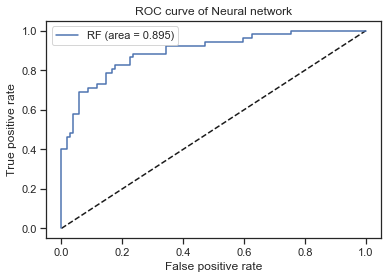

In [22]:

##Build an model(Neural model )
model = Sequential()
model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_fit=model.fit(X_train, y_train, epochs=200, batch_size=8);

_, nn_acc = model.evaluate(X_test, y_test)

y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_nn = auc(fpr, tpr)
plot_roc(fpr,tpr,auc_nn,"Neural network")



In [24]:
param_adaboost = {
 'n_estimators': [50*x for x in range(1,10)],
 'learning_rate' : [0.01*x for x in range(1,100,5)],
 'loss' : ['linear', 'square', 'exponential']
 }
param_xgb = {
    'n_estimators': [50*x for x in range(1,10)],
    'colsample_bytree': [0.1*x for x in range(1,10)],
    'max_depth': [x for x in range(1,10)],
    'reg_alpha': [0.1*x for x in range(1,20)],
    'reg_lambda': [0.1*x for x in range(1,20)],
    'subsample': [0.1*x for x in range(1,20)],
    'gamma':[0.1*x for x in range(1,20)]
}
param_rf={
    'n_estimators' : [50*x for x in range(1,10)],
    'max_depth' : [x for x in range(1,15)],
    'min_samples_split' : [5*x for x in range(1,20)],
    'min_samples_leaf' : [x for x in range(1,10)],
    'max_features' : ['auto', 'sqrt'],
    'criterion' : ['gini'],
    'bootstrap' : [True, False]
}
param_knn ={
    'leaf_size' : [3*x for x in range(1,20)],
    'n_neighbors' : [x for x in range(1,20,2)],
    'weights' : ['uniform', 'distance']
}
param_SVM = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'poly', 'sigmoid']}
para_list=[param_xgb,param_rf,param_adaboost,param_knn,param_SVM]
gridSearch_alg=[XGBClassifier(),RandomForestClassifier(),AdaBoostClassifier(),
                KNeighborsClassifier(),SVC(probability=True)]
gridSearch_alg_name=["XGBClassifier","RandomForestClassifier","AdaBoostClassifier",
                "KNeighborsClassifier","SVC"]
scores = ["accuracy","f1","roc_auc"]
all_param={}
for i in range(len(para_list)):
    for score in scores:
        all_param[gridSearch_alg_name[i]]={}
print(all_param)

{'XGBClassifier': {}, 'RandomForestClassifier': {}, 'AdaBoostClassifier': {}, 'KNeighborsClassifier': {}, 'SVC': {}}


In [ ]:

from sklearn.model_selection import GridSearchCV
for i in range(len(para_list)):
    print("#"*120)
    print("#"*120)
    print(gridSearch_alg[i])
    for score in scores:
        print("*"*120)
        print(score)
        gridsearch = GridSearchCV(gridSearch_alg[i], para_list[i],scoring=score, cv = 10, verbose = 2, 
                      n_jobs = -1)
        bestfit=gridsearch.fit(X_train,y_train)
        best_para[gridSearch_alg_name[i]][score]=bestfit.best_params_
        print(bestfit.best_params_)
        print()

In [ ]:
### Grid search for Random forest classifier
#```python    
from sklearn.model_selection import GridSearchCV
print(RandomForestClassifier())
n_estimators = [50*x for x in range(1,10)]
max_depth = [x for x in range(1,15)]
min_samples_split = [5*x for x in range(1,20)]
min_samples_leaf = [x for x in range(1,10)] 
max_features = ['auto', 'sqrt']
criterion=['gini']
bootstrap = [True, False]
rfr=RandomForestClassifier()
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,criterion=criterion,
              max_features = max_features,  min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf,bootstrap = bootstrap)

gridF = GridSearchCV(rfr, hyperF,scoring='accuracy', cv = 10, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)
#```

### Grid search for XGB Classifer 
#```python
from sklearn.model_selection import GridSearchCV
model = XGBClassifier()
param_grid = {
    'n_estimators': [50*x for x in range(1,10)],
    'colsample_bytree': [0.1*x for x in range(1,10)],
    'max_depth': [x for x in range(1,10)],
    'reg_alpha': [0.1*x for x in range(1,20)],
    'reg_lambda': [0.1*x for x in range(1,20)],
    'subsample': [0.1*x for x in range(1,20)],
    'gamma':[0.1*x for x in range(1,20)]
}
gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=10, 
        n_jobs=-1, 
        scoring="roc_auc",
        verbose=2
    )
gsf=gs.fit(X_train,y_train)

#```

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Fitting 10 folds for each of 86184 candidates, totalling 861840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.4min


In [ ]:
print(bestF.best_params_)
print(gsf.best_params_)

## Finalizing optimal model for web application 

[15:20:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:20:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:20:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:20:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

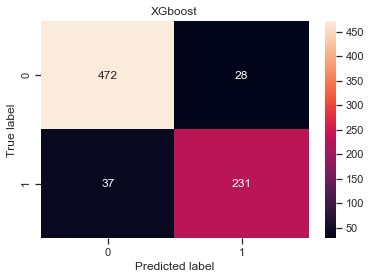

In [51]:
y = data["Outcome"]
X=data_std.drop(["Outcome"],axis=1)
X_train,X_test,y_train,y_test =  train_test_split(X,y,test_size=0.2)


model_opt = XGBClassifier(colsample_bytree = 0.5,max_depth = 8,n_estimators=100,
                          reg_alpha=1.1,reg_lambda=1.1, subsample=1,gamma=1.5)
model_opt.fit(X_train,y_train)

xgboost_opt_result= defaultdict(list)
xgboost_opt_result,df_cm = model_evalution(model_opt,"XGBoost",X,y,score,xgboost_opt_result)


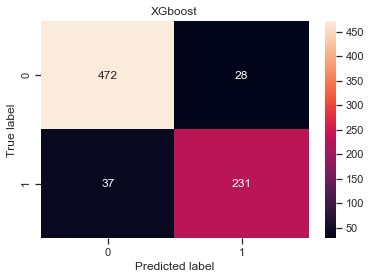

,Specificity,Sensitivity/Recall,Precision,F1 Score,Accuracy,AUC(ROC),Model
0,0.86194,0.944,0.671408,0.784705,91.545 +- 0.025,97.450 +- 0.009,XGBoost


In [52]:

plot_confusion_matrix(df_cm,"XGboost")
pd.DataFrame.from_dict(xgboost_opt_result)

## Storing trained model in a file 

In [ ]:
import pickle
# Save trained model to file
pickle.dump(model_opt, open("Diabetes.pkl", "wb"))
loaded_model = pickle.load(open("Diabetes.pkl", "rb"))
loaded_model.predict(X_test)
loaded_model.score(X_test,y_test)

